In [128]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#from sklearn.pipeline import Pipeline
#from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
#from sklearn.model_selection import ShuffleSplit, cross_val_score

from mne import Epochs, pick_types, find_events, pick_types, set_eeg_reference
from mne.channels import read_layout
from mne.io import concatenate_raws, read_raw_bdf, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP
from mne import viz
import mne
from mne.stats import bootstrap_confidence_interval
from mne.baseline import rescale
import bson
from mne.time_frequency.tfr import morlet
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch

from ssqueezepy import ssq_cwt, ssq_stft, cwt, icwt
from ssqueezepy.visuals import plot, imshow
from ssqueezepy.wavelets import Wavelet, center_frequency
from ssqueezepy.experimental import scale_to_freq,freq_to_scale

In [129]:
#n_channels = 32
sampling_freq = 128  # in Hertz
#ch_types = ['eeg'] * n_channels
#names = ['Fp1','AF3','F3','F7','FC5','FC1','C3','T7','CP5','CP1','P3','P7','PO3','O1','Oz','Pz','Fp2','AF4','Fz','F4','F8','FC6','FC2','Cz','C4','T8','CP6','CP2','P4','P8','PO4','O2']
#info = mne.create_info(ch_names=names[:n_channels], ch_types=ch_types, sfreq=sampling_freq)

data = read_raw_edf('./phototask_EPOCX_155556_2022.04.19T17.01.08.07.00.edf')#, preload=True)

Extracting EDF parameters from /mnt/c/Users/othermachine/Desktop/code/EEG-Example-Workflow/phototask_EPOCX_155556_2022.04.19T17.01.08.07.00.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [130]:
# filtering out only the channels 
data = data.copy().pick_channels(['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']).load_data() 
print(data.ch_names)
print(data.get_data().shape)
print(data.get_data().min(), data.get_data().max())


Reading 0 ... 31487  =      0.000 ...   245.992 secs...
['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']
(14, 31488)
0.003524102564102564 0.007637435897435896


0.0040471794871794866 0.004596923076923076
delta 1 3
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 3 Hz

IIR filter parameters
---------------------
elliptic bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 3.00 Hz: -0.20, -0.20 dB

Opening raw-browser...


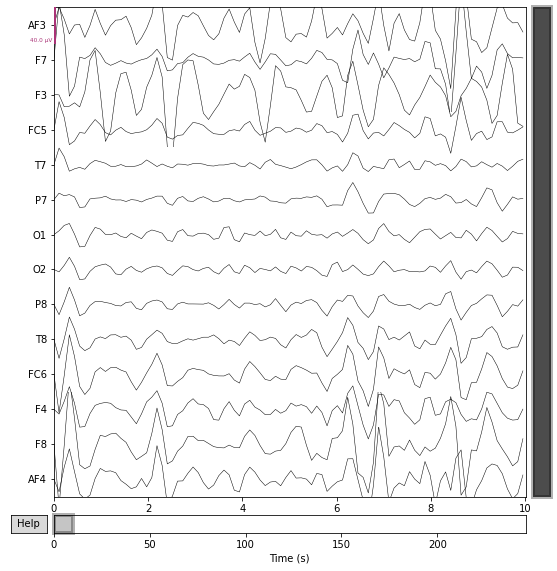

Theta 4 7
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 7 Hz

IIR filter parameters
---------------------
elliptic bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 7.00 Hz: -0.20, -0.20 dB

Opening raw-browser...


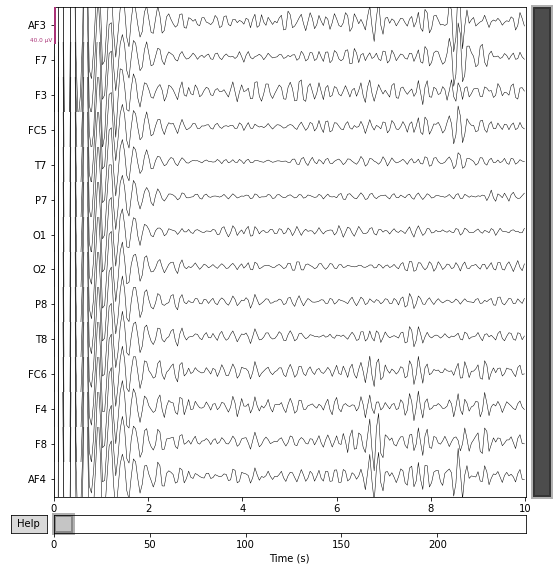

Alpha 8 12
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 12 Hz

IIR filter parameters
---------------------
elliptic bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 12.00 Hz: -0.20, -0.20 dB

Opening raw-browser...


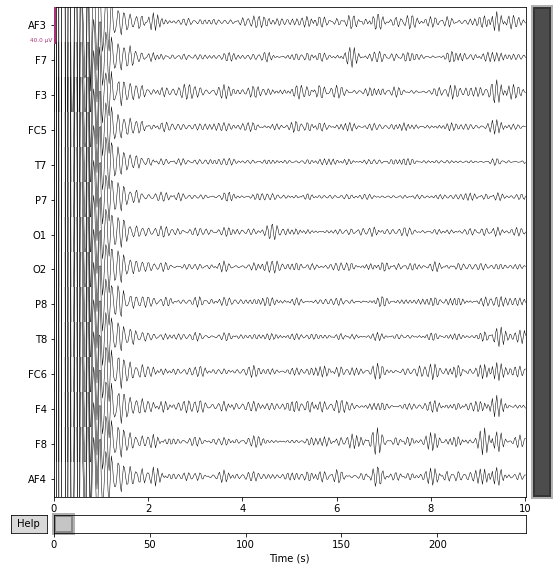

Beta 13 25
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 13 - 25 Hz

IIR filter parameters
---------------------
elliptic bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 13.00, 25.00 Hz: -0.20, -0.20 dB

Opening raw-browser...


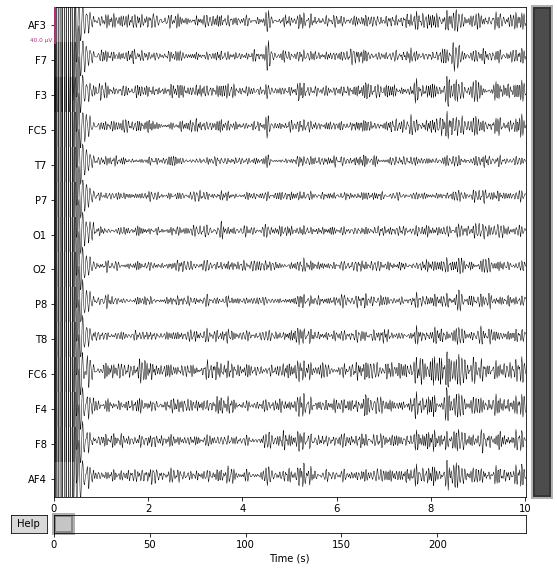

Gamma 30 45
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 30 - 45 Hz

IIR filter parameters
---------------------
elliptic bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 30.00, 45.00 Hz: -0.20, -0.20 dB

Opening raw-browser...


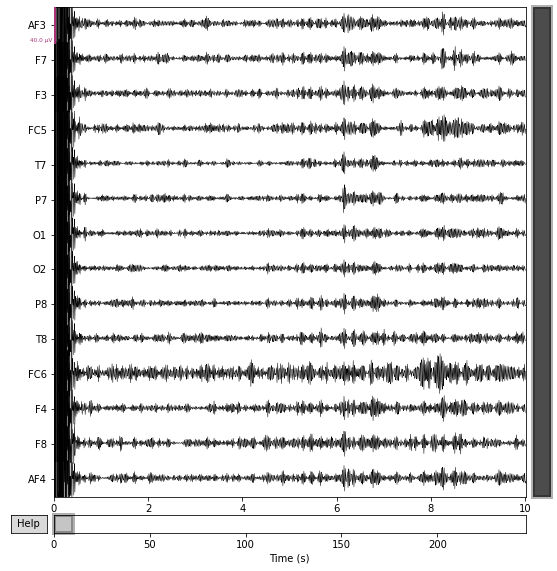

In [131]:
iter_freqs = [
    ('delta', 1, 3),
    ('Theta', 4, 7),
    ('Alpha', 8, 12),
    ('Beta', 13, 25),
    ('Gamma', 30, 45)
]
#data.filter(2,45)
#data.plot()
#data.plot(fmin=8,fmax=12)
event_id, tmin, tmax = 1, 0., 480.
#events = mne.find_events(data, stim_channel='FC1', shortest_event=1)
frequency_map = list()

print(data.get_data()[0].min(), data.get_data()[0].max())

for band, fmin, fmax in iter_freqs:
    print (band, fmin, fmax)
    data2 = data.copy()
    
    #simulated_raw = mne.io.RawArray(channelData, info)
    data2.filter(fmin,fmax,method='iir',iir_params = dict(order=4, ftype='elliptic',rp=0.1,rs=80))
    data2.plot()

    # get analytic signal (envelope)
    data.apply_hilbert(envelope=True) # originally true # epochs here
    frequency_map.append(((band, fmin, fmax), data2)) # epochs here

[(('delta', 1, 3), <RawEDF | phototask_EPOCX_155556_2022.04.19T17.01.08.07.00.edf, 1 x 14592 (114.0 s), ~120 kB, data loaded>), (('Theta', 4, 7), <RawEDF | phototask_EPOCX_155556_2022.04.19T17.01.08.07.00.edf, 1 x 14592 (114.0 s), ~120 kB, data loaded>), (('Alpha', 8, 12), <RawEDF | phototask_EPOCX_155556_2022.04.19T17.01.08.07.00.edf, 1 x 14592 (114.0 s), ~120 kB, data loaded>), (('Beta', 13, 25), <RawEDF | phototask_EPOCX_155556_2022.04.19T17.01.08.07.00.edf, 1 x 14592 (114.0 s), ~120 kB, data loaded>), (('Gamma', 30, 45), <RawEDF | phototask_EPOCX_155556_2022.04.19T17.01.08.07.00.edf, 1 x 14592 (114.0 s), ~120 kB, data loaded>)]
(1, 14592)
(14592,)
Applying baseline correction (mode: mean)
(14592,)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
[0.00000000e+00 5.55623452e-13 2.22513343e-12 ... 1.01470870e-11
 2.51710134e-12 6.79872622e-16]
(1, 14592)
(14592,)
Applying baseline correction (mode: mean)
(14592,)
Applying baseline correction (mode: m

Text(0.5, 0, 'Time [ms]')

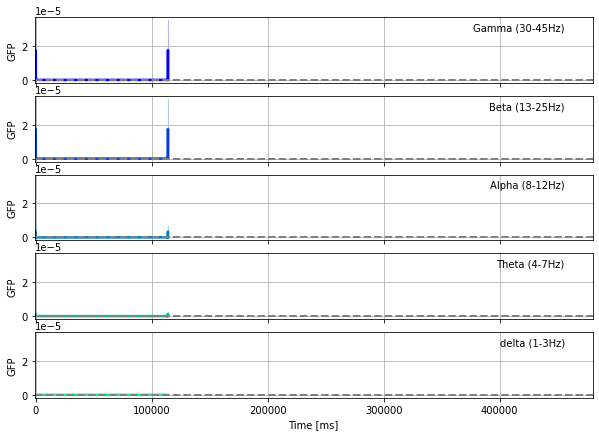

In [118]:
def stat_fun(x):
    """Return sum of squares."""
    return np.sum(x ** 2, axis=0)


# Plot
print(frequency_map)
fig, axes = plt.subplots(5, 1, figsize=(10, 7), sharex=True, sharey=True)
colors = plt.get_cmap('winter_r')(np.linspace(0, 1, 5))
for ((freq_name, fmin, fmax), average), color, ax in zip(
        frequency_map, colors, axes.ravel()[::-1]):
    times = average.times * 1e3
    print(average.get_data().shape)
    gfp = np.sum(average.get_data() ** 2, axis=0)
    print(gfp.shape)
    gfp = mne.baseline.rescale(gfp, times, baseline=(None,0))
    print(gfp.shape)
    #gfp *= 1000
    ax.plot(times, gfp, label=freq_name, color=color, linewidth=2.5)
    ax.axhline(0, linestyle='--', color='grey', linewidth=2)
    ci_low, ci_up = bootstrap_confidence_interval(average.get_data(), random_state=0,
                                                  stat_fun=stat_fun)
    ci_low = rescale(ci_low, average.times, baseline=(None,0))
    ci_up = rescale(ci_up, average.times, baseline=(None,0))
    print(gfp)
    ax.fill_between(times, gfp + ci_up, gfp - ci_low, color=color, alpha=0.3)
    ax.grid(True)
    ax.set_ylabel('GFP')
    ax.annotate('%s (%d-%dHz)' % (freq_name, fmin, fmax),
                xy=(0.95, 0.8),
                horizontalalignment='right',
                xycoords='axes fraction')
    ax.set_xlim(-1000, 480000)

axes.ravel()[-1].set_xlabel('Time [ms]')

In [120]:
#    ('delta', 1, 3),
#    ('Theta', 4, 7),
#    ('Alpha', 8, 12),
#    ('Beta', 13, 25),
#    ('Gamma', 30, 45)
def getScaleForFrequency(wavelet=Wavelet('morlet'),fromFreq=1,toFreq=3, fs=128.0):
    #print([fromFreq/fs,toFreq/fs])
    output = freq_to_scale(np.array([fromFreq,toFreq]),wavelet,wavelet.N,fs=fs, n_search_scales=100)
    output = output[::-1]
    scale = (output[1] - output[0]) / 100.0
    output = np.arange(output[0],output[1],scale)
    return output


def extractSignal(signal, wavelet, scales, fs=128.0):
    coefficients,scales = cwt(signal,wavelet=wavelet,scales=scales,fs=fs)
    newSignal = icwt(coefficients,scales=scales)
    return newSignal, coefficients, scales

def extractBands(signal, wavelet=Wavelet('morlet'), fs=128.0):
    deltaScales = getScaleForFrequency(fromFreq=1,toFreq=3,wavelet=wavelet,fs=fs)
    deltaSignal, coefficients, scales = extractSignal(signal, wavelet, deltaScales, fs=fs)
    print(coefficients.shape)
    print(coefficients[0])
    #gfp = np.sum(np.abs(coefficients) ** 2, axis=0)
    #gfp = mne.baseline.rescale(gfp, times, baseline=None)
    #plt.plot(times, gfp, label=freq_name, color=color, linewidth=2.5)
    #plt.show()
    #imshow(coefficients, abs=1, yticks=scale_to_freq(scales, wavelet, wavelet.N, fs=fs), cmap='turbo', show=1)
    
    thetaScales = getScaleForFrequency(fromFreq=4,toFreq=7,wavelet=wavelet,fs=fs)
    thetaSignal, coefficients, scales = extractSignal(signal, wavelet, thetaScales, fs=fs)
    #gfp = np.sum(np.abs(coefficients) ** 2, axis=0)
    #gfp = mne.baseline.rescale(gfp, times, baseline=None)
    #plt.plot(times, gfp, label=freq_name, color=color, linewidth=2.5)
    #plt.show()
    #imshow(coefficients, abs=1, yticks=scale_to_freq(scales, wavelet, wavelet.N, fs=fs), cmap='turbo', show=1)
    
    alphaScales = getScaleForFrequency(fromFreq=8,toFreq=12,wavelet=wavelet,fs=fs)
    alphaSignal, coefficients, scales = extractSignal(signal, wavelet, alphaScales, fs=fs)
    #imshow(coefficients, abs=1, yticks=scale_to_freq(scales, wavelet, wavelet.N, fs=fs), cmap='turbo', show=1)
    
    betaScales = getScaleForFrequency(fromFreq=13,toFreq=25,wavelet=wavelet,fs=fs)
    betaSignal, coefficients, scales = extractSignal(signal, wavelet, betaScales, fs=fs)
    #imshow(coefficients, abs=1, yticks=scale_to_freq(scales, wavelet, wavelet.N, fs=fs), cmap='turbo', show=1)
    
    gammaScales = getScaleForFrequency(fromFreq=30,toFreq=45,wavelet=wavelet,fs=fs)
    gammaSignal, coefficients, scales = extractSignal(signal, wavelet, gammaScales, fs=fs)
    #imshow(coefficients, abs=1, yticks=scale_to_freq(scales, wavelet, wavelet.N, fs=fs), cmap='turbo', show=1)
    #print(scale_to_freq(scales, wavelet, 1024, fs=fs))
    #print(scales)
    #print(getScaleForFrequency(fromFreq=30,toFreq=45,wavelet=wavelet,fs=fs))
    return deltaSignal, thetaSignal, alphaSignal, betaSignal, gammaSignal

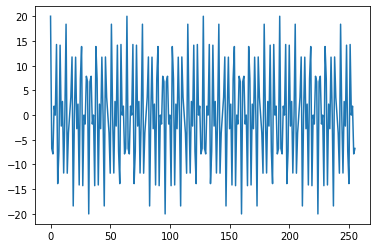

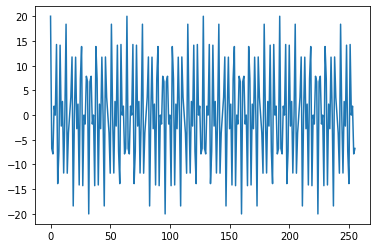

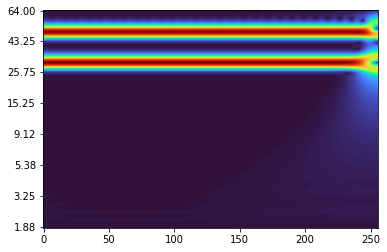

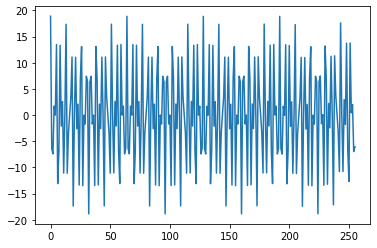

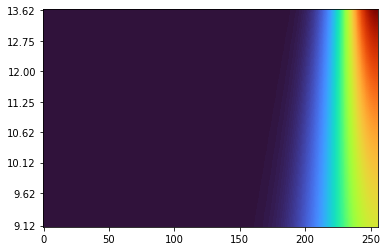

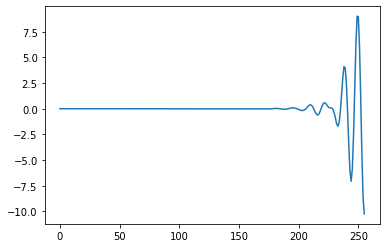

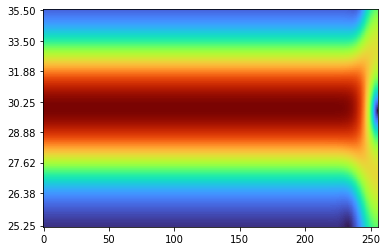

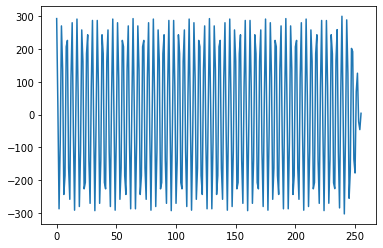

In [121]:
def viz(x, Tx=None, Wx=None):
    if type(Wx) != type(None):
        plt.imshow(np.abs(Wx), aspect='auto', cmap='turbo')
        plt.show()
    if type(Tx) != type(None):
        plt.imshow(np.abs(Tx), aspect='auto', vmin=0, vmax=.2, cmap='turbo')
        plt.show()

        
        
def viz2(x, Tx=None, yticks=None):
    if type(Tx) != type(None):
        #print(Tx.shape)
        a = np.abs(Tx).max() * .9
        imshow(Tx, abs=1,yticks=yticks,cmap='turbo', show=1)
        #plt.show()
#%%# Define signal ####################################
N = 128
t = np.arange(0,2,1/N)
#print(t)
x = xo =  np.cos(2*np.pi * 50 * t) * 10 + np.cos(2*np.pi * 30 * t) * 10
#xo += xo[::-1]  # add self reflected
#x = xo + np.sqrt(2) * np.random.randn(N)  # add noise

plt.plot(xo); plt.show()
plt.plot(x);  plt.show()

wavelet = Wavelet('morlet')

#scalar = center_frequency(wavelet,1.01,kind='peak')*N 

#print(scalar/scales)
#print(wavelet.xifn(1)*N)

coefficients,scales = cwt(x,wavelet=wavelet,t=t,scales='log')

scala = scale_to_freq(scales,wavelet, 1024, fs=N, padtype='None')

viz2(x,coefficients,scala)

#coefficients = coefficients[100:200,:]
#scales = scales[100:200]
y0 = icwt(coefficients,scales=scales)

plt.plot(y0); plt.show()

#print(scales)




coefficients,scales = cwt(x,wavelet=wavelet,scales=np.arange(20,30,.1),t=t)
#print(center_frequency(wavelet,1.1,kind='energy'))


viz2(xo,coefficients,scale_to_freq(scales,wavelet, 1024, fs=N))

coefficients = coefficients[2:,:]
scales = scales[2:]





y1 = icwt(coefficients,scales=scales)
#print(y1)
plt.plot(y1); plt.show()


scales = getScaleForFrequency(fromFreq=25,toFreq=35,wavelet=wavelet,fs=N)
coefficients,scales = cwt(x,wavelet=wavelet,scales=scales,t=t)

viz2(xo,coefficients,scale_to_freq(scales,wavelet, 1024, fs=N))

y1 = icwt(coefficients,scales=scales)
#print(y1)
plt.plot(y1); plt.show()


#help(cwt)

(100, 23040)
[-3.3754750e-06+2.2737368e-13j -3.3412903e-06-4.7931599e-07j
 -3.2394260e-06-9.4892914e-07j ...  9.2380560e-08-4.0279872e-08j
  9.8231340e-08-2.0503705e-08j  1.0020335e-07-2.2737368e-13j]
delta


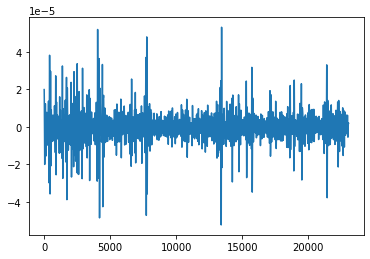

In [122]:
deltaSignal, thetaSignal, alphaSignal, betaSignal, gammaSignal = extractBands(np.array(data.get_data()[0]), fs=128)

print("delta")
plt.plot(deltaSignal); plt.show() 

theta


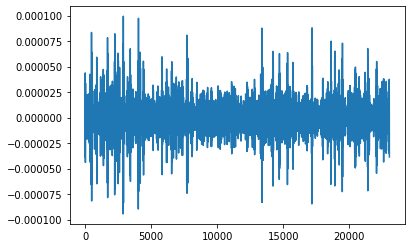

In [123]:
print('theta')
plt.plot(thetaSignal); plt.show()

alpha


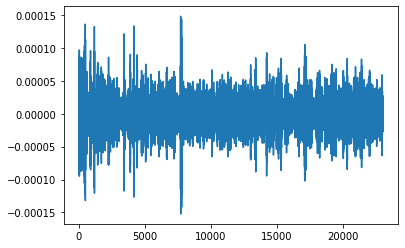

In [124]:
print('alpha')
plt.plot(alphaSignal); plt.show()

beta


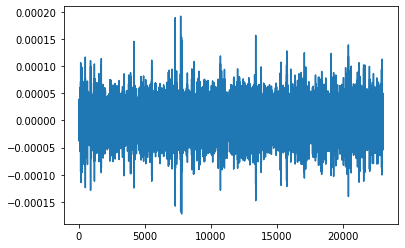

In [125]:
print('beta')
plt.plot(betaSignal); plt.show()

gamma


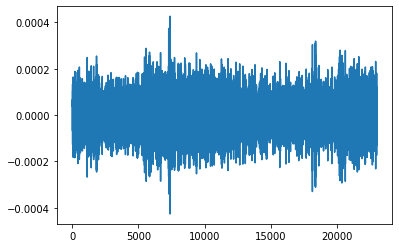

In [126]:
print('gamma')
plt.plot(gammaSignal); plt.show()

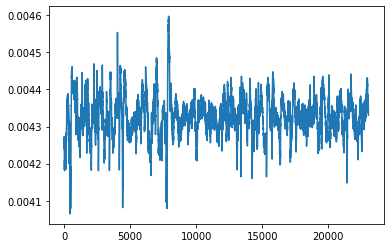

In [127]:
plt.plot(np.array(data.get_data()[0])); plt.show()